In [1]:
from dotenv import load_dotenv
import os

# Looking for .env file and loading it
load_dotenv() 

nyt_api = os.getenv("NYT_ID")
guardian_api =  os.getenv("GUARDIAN_ID")

# Get the id and secret from the .env
spotify_client_id = os.getenv("SPOTIFY_CLIENT_ID" )
spotify_client_secret = os.getenv("SPOTIFY_CLIENT_SECRET")
genius_token = os.getenv("GENIUS_API_TOKEN")

# News Collection
Pull today's headline from the NYT API

In [2]:
! pip install requests

In [3]:
import requests

nyt_api = "ZOlnBKpA3FMv3bpiyDpJSkZmroryqlKu"
URL = f'https://api.nytimes.com/svc/topstories/v2/home.json?api-key={nyt_api}'

response = requests.get(URL)

nyt_articles = []


if response.status_code == 200:
    data = response.json()
    if data['results']:
        # Assume the first article is the main front-page article
        for article in data['results']:
            nyt_articles.append(article['title'] + ": " + article['title'])
    else:
        print("No articles found.")
else:
    print(f"Error: {response.status_code}, {response.text}")
    
print(len(nyt_articles))


24


In [4]:
import requests
from datetime import datetime


# Parameters
SECTION = 'us-news'
DATE = datetime.now().strftime('%Y-%m-%d')
URL = 'https://content.guardianapis.com/search'
NUM_ARTICLES = 8

guardian_api = "e86b7a1d-c0fc-4b00-a820-ce766a4aabcc"

params = {
    'section': SECTION,
    'from-date': DATE,
    'to-date': DATE,
    'order-by': 'newest',
    'page-size': NUM_ARTICLES,
    'show-fields': 'trailText',
    'api-key': guardian_api
}

guardian_articles = []

try:
    response = requests.get(URL, params=params)
    response.raise_for_status()
    data = response.json()

    if data.get('response', {}).get('status') == 'ok' and data['response']['results']:
        articles = data['response']['results']
        with open('guardian_us_headlines.txt', 'w', encoding='utf-8') as file:
            for idx, article in enumerate(articles, start=1):
                title = article.get('webTitle', 'No Title')
                abstract = article.get('fields', {}).get('trailText', 'No Abstract')
                guardian_articles.append(title + ": " + abstract)
    else:
        print("No articles found for today.")

except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")

print(len(guardian_articles))

7


# NLP Analysis
Calculate sentiment of news articles

In [5]:
! pip install nltk

In [6]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Assume nyt_articles and guardian_articles are already lists of headlines

# Prepare text
nyt_text = ' '.join(nyt_articles)
guardian_text = ' '.join(guardian_articles)

# Stopwords
stop_words = set(stopwords.words("english"))

# NYT Sentiment
tokenized_nyt = word_tokenize(nyt_text)
filtered_nyt = [word.lower() for word in tokenized_nyt if word.isalnum() and word.lower() not in stop_words]

sentiment_analyzer = SentimentIntensityAnalyzer()
news_sentiment_nyt = sentiment_analyzer.polarity_scores(' '.join(filtered_nyt))
print("NYT Headline Sentiment:", news_sentiment_nyt['compound'])

# Guardian Sentiment
tokenized_guardian = word_tokenize(guardian_text)
filtered_guardian = [word.lower() for word in tokenized_guardian if word.isalnum() and word.lower() not in stop_words]

news_sentiment_guardian = sentiment_analyzer.polarity_scores(' '.join(filtered_guardian))
print("Guardian Headline Sentiment:", news_sentiment_guardian['compound'])


NYT Headline Sentiment: -0.993
Guardian Headline Sentiment: -0.4215


[nltk_data] Downloading package punkt to /Users/noahpurow/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noahpurow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/noahpurow/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Song Recs
Search for songs in the spotify API that have audio features we matched with the mood

In [7]:
! pip install spotipy beautifulsoup4

In [8]:

import base64
from requests import post
from bs4 import BeautifulSoup

In [9]:
def get_token(client_id, client_secret):
    # Encode the client ID and client secret
    auth_string = client_id + ":" + client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = base64.b64encode(auth_bytes).decode("utf-8")
    
    # Define the URL and headers for the POST request
    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": f"Basic {auth_base64}",
        "Content-Type": "application/x-www-form-urlencoded"
    }
    
    # Set the data payload for the POST request
    data = {"grant_type": "client_credentials"}
    
    # Make the POST request to get the token
    result = post(url, headers=headers, data=data)
    token = result.json()
    # notice how we JSONify the Response object

    return token # Return the access token from the JSON response

In [10]:
# Check the token
token = get_token("8c428039b02b4ea995601e5e6a1a4fd0", "dc74317bb655405a89c1e9270702dbfd")
access_token = token["access_token"]
print(access_token)

BQCiW2j1ksyDnAoeME6iGnfsPIC96XCVCTkOD07bIcl2ST0iCDoOlLlA7k9eC165GAAOIt4QonrdjI_HPxwhsZLIZW7AO70C0MNIYo7tQf2XuhiJIIxFPluNkB9Ko3GITvlW900Eknk


In [18]:
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER Lexicon if you haven't already
nltk.download('vader_lexicon')

# Create Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# --- Spotify API Part ---
def get_usa_top_50(token):
    playlist_id = '6UeSakyzhiEt4NB3UAd6NQ'  # USA Top 50 Playlist ID
    url = f'https://api.spotify.com/v1/playlists/{playlist_id}'

    headers = {'Authorization': f'Bearer {token}'}

    response = requests.get(url, headers=headers)
    response.raise_for_status()
    playlist_data = response.json()

    top_50_tracks = []

    for item in playlist_data['tracks']['items']:
        track = item['track']
        track_name = track['name']
        artist_name = track['artists'][0]['name']
        top_50_tracks.append({'track': track_name, 'artist': artist_name})

    return top_50_tracks

# --- Genius API Part ---
def get_genius_url(genius_token, artist, title):
    search_url = 'https://api.genius.com/search'
    headers = {'Authorization': f'Bearer {genius_token}'}
    query = f"{artist} {title}"
    params = {'q': query}
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    data = response.json()
    hits = data['response']['hits']
    if hits:
        return hits[0]['result']['url']
    return None

def get_lyrics(genius_url):
    page = requests.get(genius_url)
    soup = BeautifulSoup(page.text, 'html.parser')
    lyrics_containers = soup.find_all('div', attrs={"data-lyrics-container": "true"})
    lyrics = "\n".join([div.get_text(strip=True) for div in lyrics_containers])
    return lyrics

# --- Main Program ---

# You must provide valid tokens
spotify_access_token = access_token
genius_access_token = "2WI-r2Et6tJP5xoh1fsRV1tRz30vnnOFk5A6TCzhNAbWfBN7bIodIpn_AiNQUWB7"

usa_top_50 = get_usa_top_50(spotify_access_token)
sentiments = {}

for song in usa_top_50:
    artist = song['artist']
    title = song['track']
    print(f"\nProcessing: {artist} - {title}")
    try:
        genius_url = get_genius_url(genius_access_token, artist, title)
        if genius_url:
            lyrics = get_lyrics(genius_url)
            sentiment = sia.polarity_scores(lyrics)
            sentiments[f"{artist} - {title}"] = {
            'compound': sentiment['compound'],
            'lyrics': lyrics }
        else:
            print("Genius URL not found.")
    except Exception as e:
        print(f"Error processing {artist} - {title}: {e}")

# Optionally, print final sentiment dictionary
print("\nSentiment scores for all songs:")
for song, sentiment in sentiments.items():
    print(f"{song}: {sentiment['compound']}")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/noahpurow/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Processing: Kendrick Lamar - luther (with sza)

Processing: Drake - NOKIA

Processing: Lady Gaga - Die With A Smile

Processing: BigXthaPlug - All The Way (feat. Bailey Zimmerman)

Processing: Chappell Roan - Pink Pony Club

Processing: Shaboozey - A Bar Song (Tipsy)

Processing: Alex Warren - Ordinary

Processing: Teddy Swims - Lose Control

Processing: Morgan Wallen - I'm The Problem

Processing: Benson Boone - Beautiful Things

Processing: Billie Eilish - BIRDS OF A FEATHER

Processing: Morgan Wallen - Just In Case

Processing: ROSÉ - APT.

Processing: Doechii - Anxiety

Processing: Gracie Abrams - That’s So True

Processing: Kendrick Lamar - Not Like Us

Processing: Sabrina Carpenter - Espresso

Processing: Kendrick Lamar - tv off (feat. lefty gunplay)

Processing: Morgan Wallen - Love Somebody

Processing: Post Malone - I Had Some Help (Feat. Morgan Wallen)

Processing: Leon Thomas - MUTT

Processing: Lola Young - Messy

Processing: Kendrick Lamar - squabble up

Processing: Tate 

In [12]:
goal = news_sentiment_nyt['compound']
distance = 100
closest_song = "None"
closest_artist = "None"

for song, sentiment in sentiments.items():
    if abs(sentiment['compound'] - goal) < distance:
        distance = abs(sentiment['compound'] - goal)
        closest_song = song.split(" - ")[1]
        closest_artist = song.split(" - ")[0]
        
print(f"NYT: We recommend you listen to: {closest_song} by {closest_artist}")

goal = news_sentiment_guardian['compound']
distance = 100
closest_song = "None"
closest_artist = "None"

for song, sentiment in sentiments.items():
    if abs(sentiment['compound'] - goal) < distance:
        distance = abs(sentiment['compound'] - goal)
        closest_song = song.split(" - ")[1]
        closest_artist = song.split(" - ")[0]
        
print(f"Guardian: We recommend you listen to: {closest_song} by {closest_artist}")

NYT: We recommend you listen to: I'm A Little Crazy by Morgan Wallen
Guardian: We recommend you listen to: Azizam by Ed Sheeran


[nltk_data] Downloading package punkt to /Users/noahpurow/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noahpurow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/_p/gqrzzrfj0x34qw1lnnq14xsr0000gn/T/ipykernel_52475/856633552.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=compound_scores_sorted, y=song_titles_sorted, palette="coolwarm")


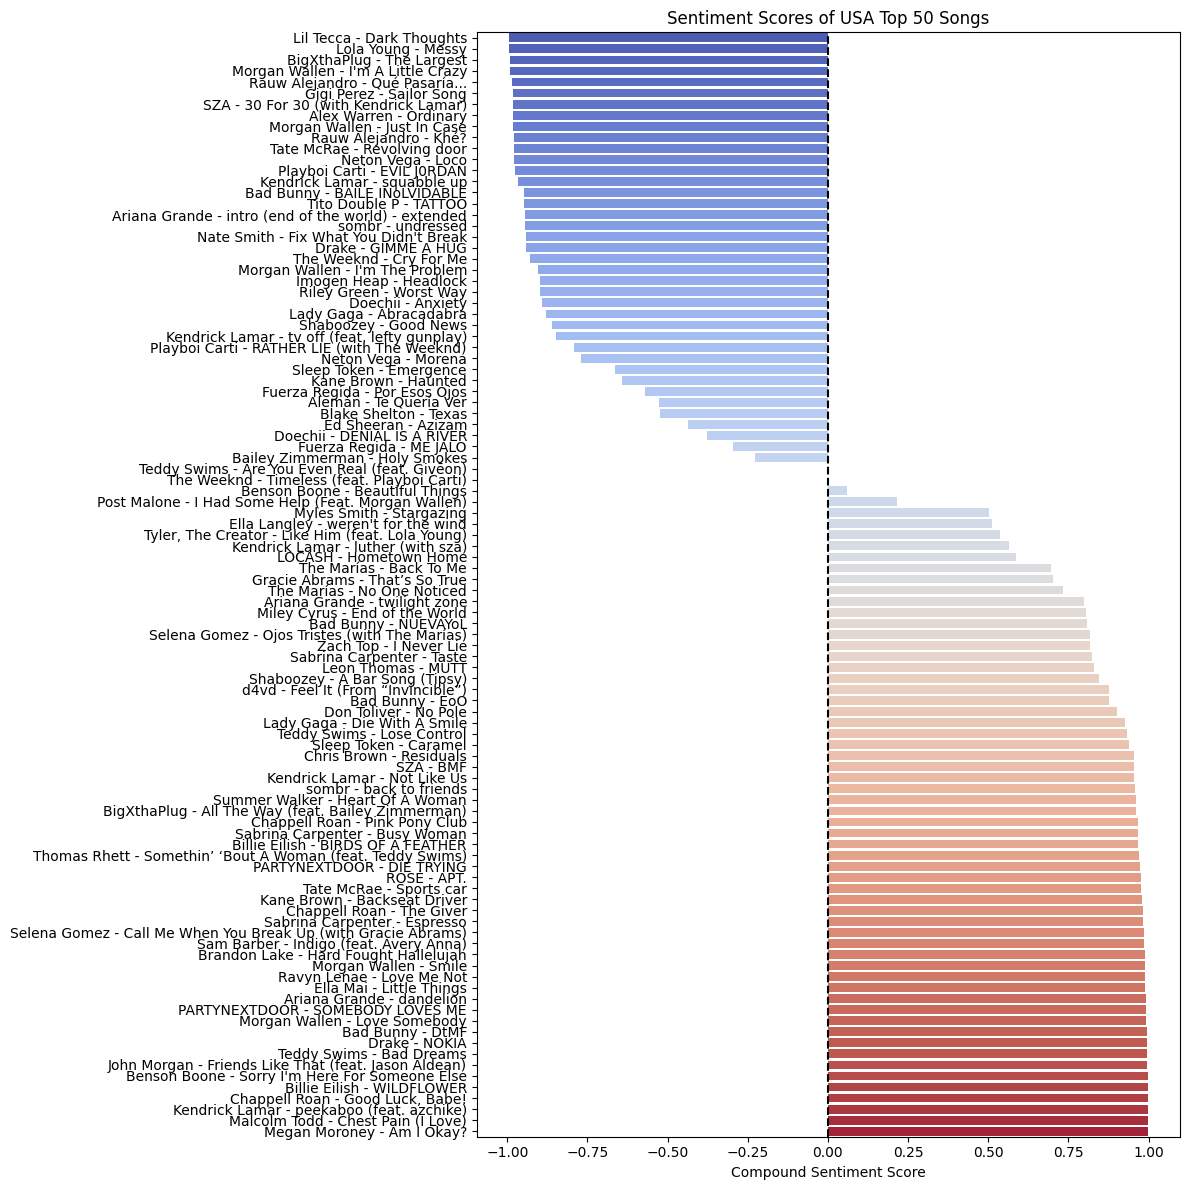

/var/folders/_p/gqrzzrfj0x34qw1lnnq14xsr0000gn/T/ipykernel_52475/856633552.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outlets, y=sentiment_scores, palette="pastel")


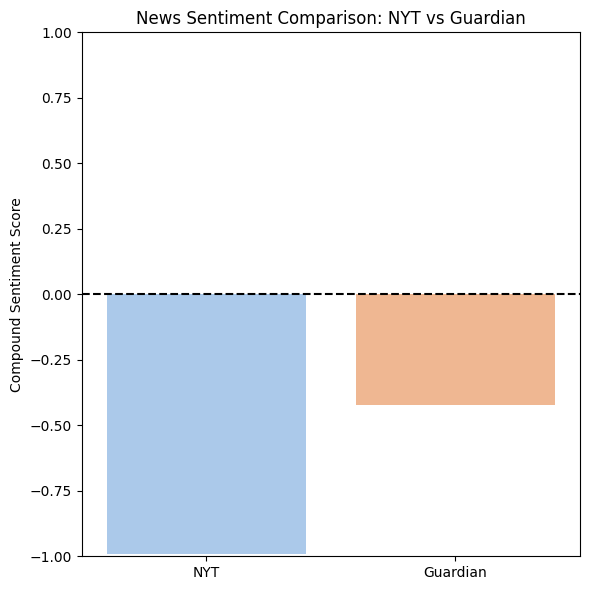

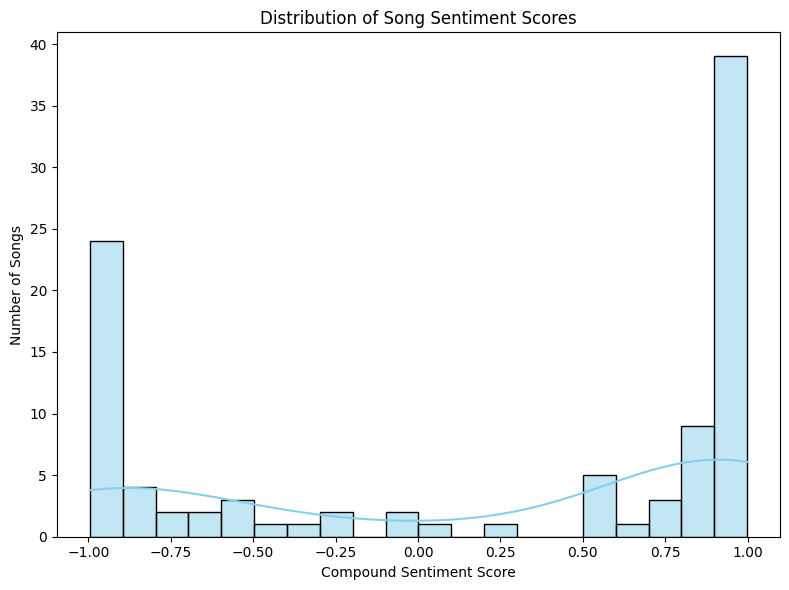

/var/folders/_p/gqrzzrfj0x34qw1lnnq14xsr0000gn/T/ipykernel_52475/856633552.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=happy_scores, y=happy_titles, palette="Blues_d")


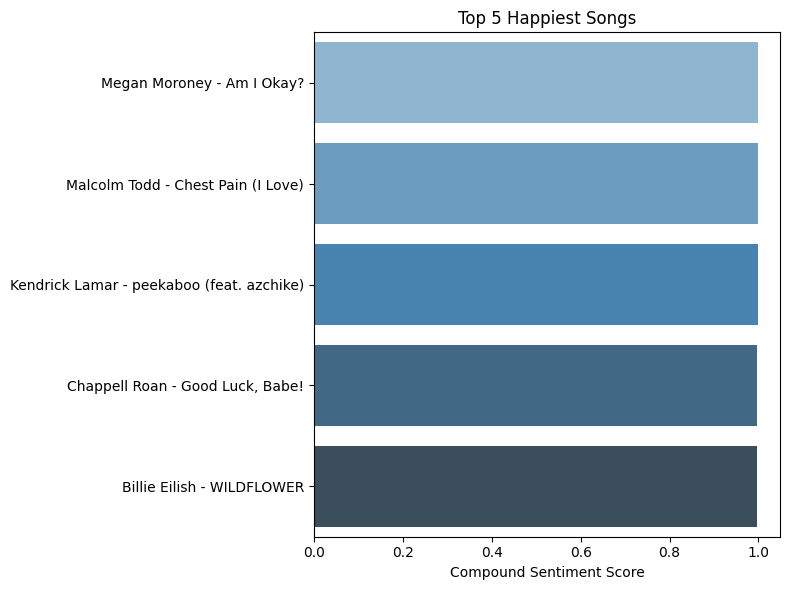

/var/folders/_p/gqrzzrfj0x34qw1lnnq14xsr0000gn/T/ipykernel_52475/856633552.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sad_scores, y=sad_titles, palette="Reds_d")


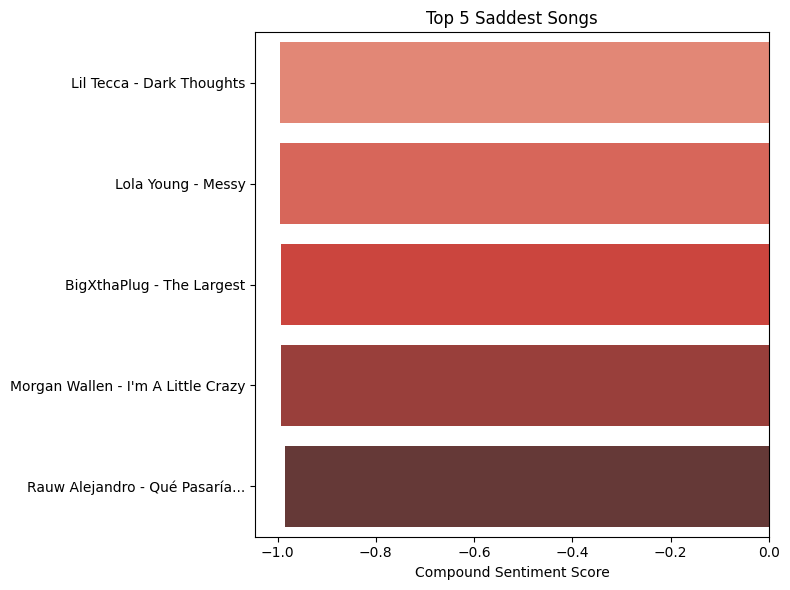

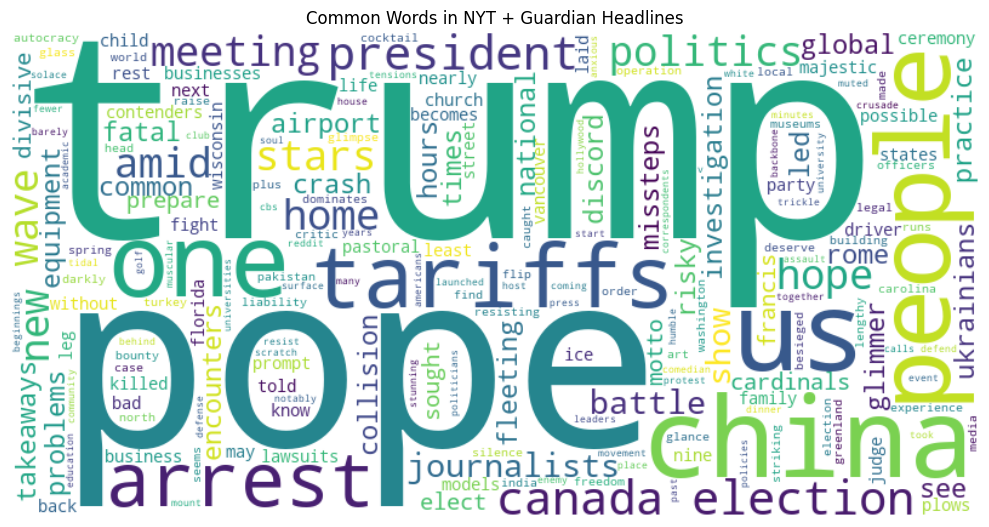

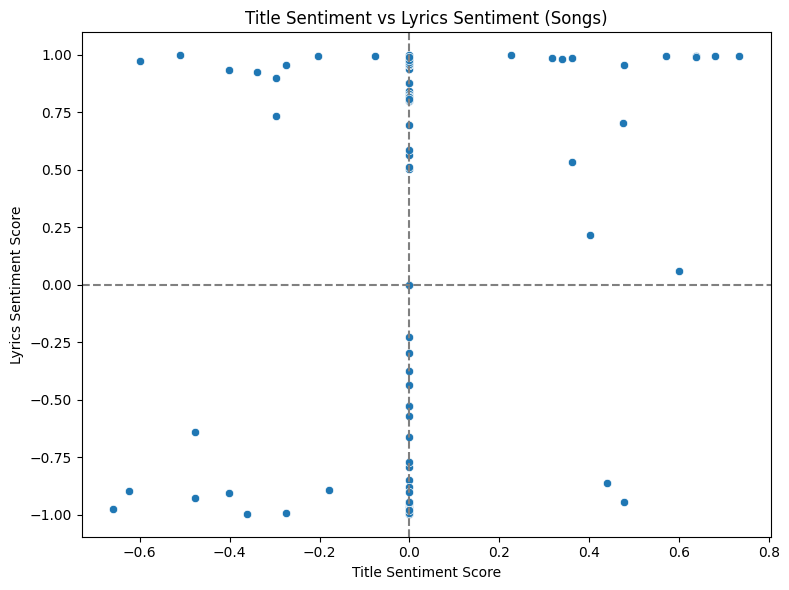

/var/folders/_p/gqrzzrfj0x34qw1lnnq14xsr0000gn/T/ipykernel_52475/856633552.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=positive_scores, y=positive_headlines, palette="Greens_d")
/var/folders/_p/gqrzzrfj0x34qw1lnnq14xsr0000gn/T/ipykernel_52475/856633552.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=negative_scores, y=negative_headlines, palette="Reds_d")
/var/folders/_p/gqrzzrfj0x34qw1lnnq14xsr0000gn/T/ipykernel_52475/856633552.py:146: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


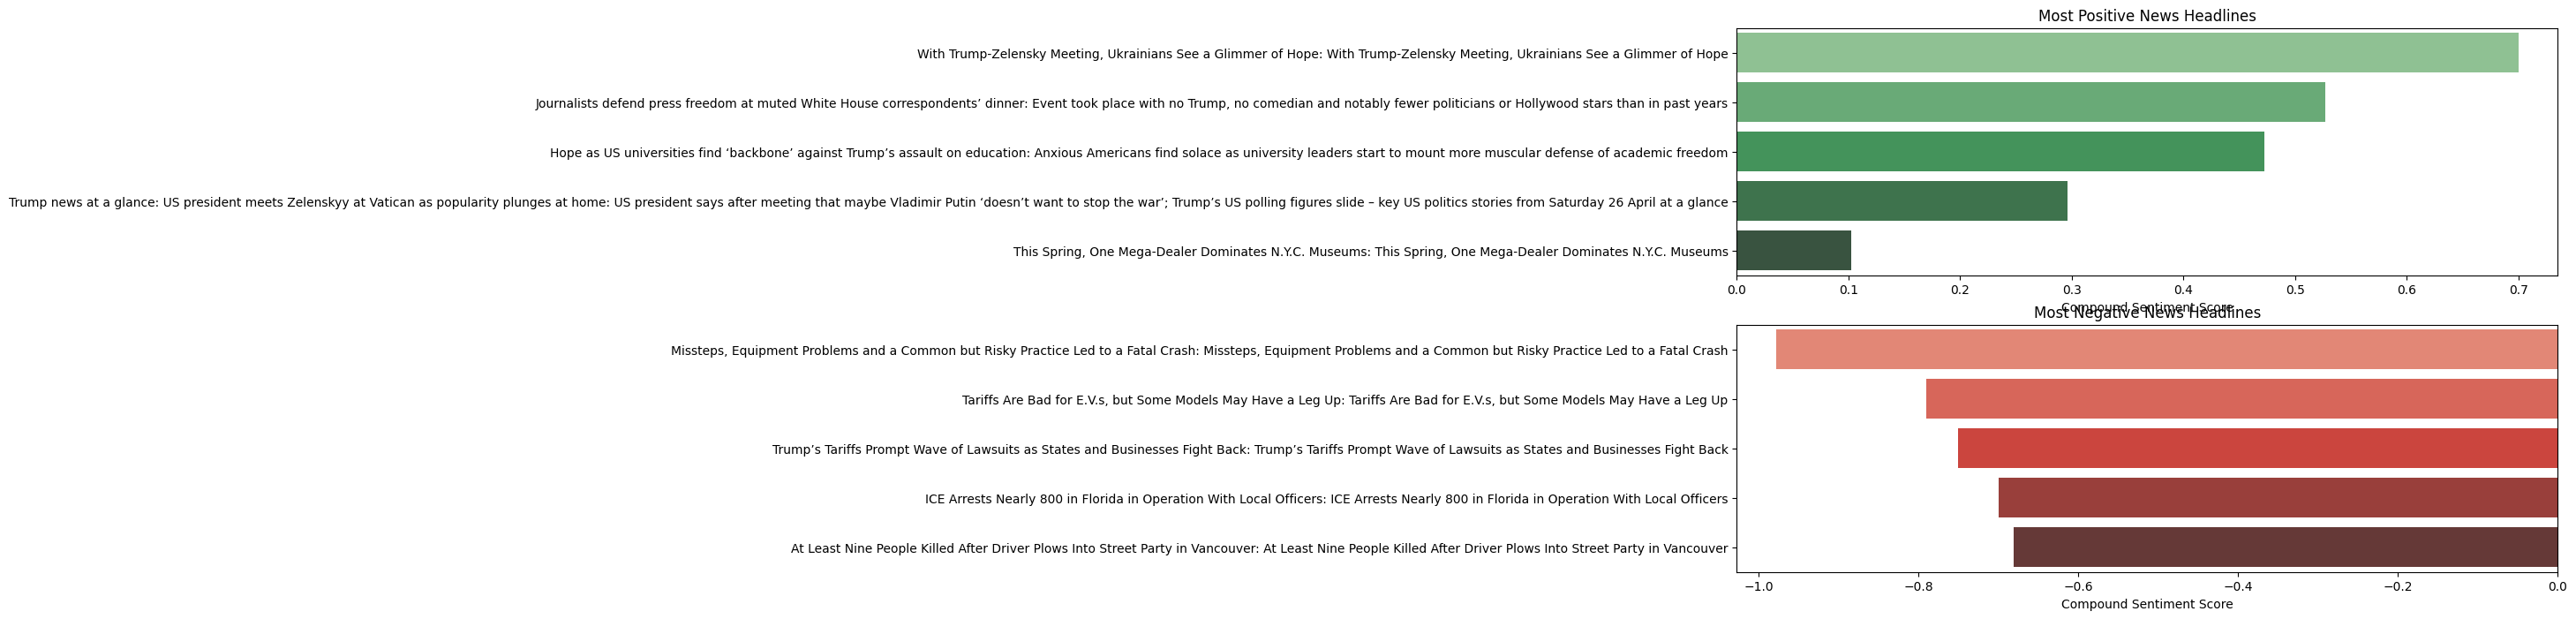

In [20]:
# 📚 Imports
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

# 📥 Download NLTK data if not already
nltk.download('punkt')
nltk.download('stopwords')

# 📊 Assumes you have these ready:
# - sentiments: { "Artist - Title": { 'compound': score, 'lyrics': text, ... } }
# - nyt_articles: list of NYT headlines
# - guardian_articles: list of Guardian headlines
# - news_sentiment_nyt: VADER output for NYT
# - news_sentiment_guardian: VADER output for Guardian

# --- PREPARE DATA ---
song_titles = list(sentiments.keys())
compound_scores = [sentiments[song]['compound'] for song in song_titles]
sorted_data = sorted(zip(compound_scores, song_titles))
compound_scores_sorted, song_titles_sorted = zip(*sorted_data)

outlets = ['NYT', 'Guardian']
sentiment_scores = [news_sentiment_nyt['compound'], news_sentiment_guardian['compound']]

# --- OUTPUT SETTINGS ---
save_figures = True  # set False if you don't want to save graphs
figure_counter = 1

def save_or_show(title):
    global figure_counter
    if save_figures:
        plt.savefig(f'figure{figure_counter}_{title}.png', bbox_inches='tight')
    plt.show()
    figure_counter += 1

# --- PLOT ALL FIGURES ---

# 1️⃣ Top 50 Songs Sentiment Bar Chart
plt.figure(figsize=(12, 12))
sns.barplot(x=compound_scores_sorted, y=song_titles_sorted, palette="coolwarm")
plt.title('Sentiment Scores of USA Top 50 Songs')
plt.xlabel('Compound Sentiment Score')
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
save_or_show('top50_sentiment')

# 2️⃣ NYT vs Guardian Sentiment Comparison
plt.figure(figsize=(6, 6))
sns.barplot(x=outlets, y=sentiment_scores, palette="pastel")
plt.title('News Sentiment Comparison: NYT vs Guardian')
plt.ylabel('Compound Sentiment Score')
plt.ylim(-1, 1)
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
save_or_show('nyt_guardian_sentiment')

# 3️⃣ Distribution of Song Sentiments
plt.figure(figsize=(8,6))
sns.histplot(compound_scores, bins=20, kde=True, color="skyblue")
plt.title('Distribution of Song Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Number of Songs')
plt.tight_layout()
save_or_show('song_sentiment_distribution')

# 4️⃣ Top 5 Happiest Songs
top5_happy = sorted(zip(compound_scores, song_titles), reverse=True)[:5]
happy_scores, happy_titles = zip(*top5_happy)
plt.figure(figsize=(8,6))
sns.barplot(x=happy_scores, y=happy_titles, palette="Blues_d")
plt.title('Top 5 Happiest Songs')
plt.xlabel('Compound Sentiment Score')
plt.tight_layout()
save_or_show('top5_happy_songs')

# 5️⃣ Top 5 Saddest Songs
top5_sad = sorted(zip(compound_scores, song_titles))[:5]
sad_scores, sad_titles = zip(*top5_sad)
plt.figure(figsize=(8,6))
sns.barplot(x=sad_scores, y=sad_titles, palette="Reds_d")
plt.title('Top 5 Saddest Songs')
plt.xlabel('Compound Sentiment Score')
plt.tight_layout()
save_or_show('top5_sad_songs')

# 6️⃣ Word Cloud of News Headlines
news_text = ' '.join(nyt_articles + guardian_articles)
stop_words = set(stopwords.words('english'))
filtered_words = ' '.join([word for word in nltk.word_tokenize(news_text.lower()) if word.isalnum() and word not in stop_words])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_words)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in NYT + Guardian Headlines')
plt.tight_layout()
save_or_show('wordcloud_news')

# 8️⃣ Song Title Sentiment vs Lyrics Sentiment
title_sentiments = []
lyrics_sentiments = []

for song_name, sentiment_data in sentiments.items():
    artist, title = song_name.split(' - ', 1) if ' - ' in song_name else ("Unknown", song_name)
    title_score = sia.polarity_scores(title)['compound']
    title_sentiments.append(title_score)
    lyrics_sentiments.append(sentiment_data['compound'])

plt.figure(figsize=(8,6))
sns.scatterplot(x=title_sentiments, y=lyrics_sentiments)
plt.title('Title Sentiment vs Lyrics Sentiment (Songs)')
plt.xlabel('Title Sentiment Score')
plt.ylabel('Lyrics Sentiment Score')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
save_or_show('title_vs_lyrics_sentiment')

# 9️⃣ Most Positive and Most Negative News Headlines
all_headlines = nyt_articles + guardian_articles
headline_sentiments = [(headline, sia.polarity_scores(headline)['compound']) for headline in all_headlines]

# Sort headlines by sentiment
most_positive = sorted(headline_sentiments, key=lambda x: x[1], reverse=True)[:5]
most_negative = sorted(headline_sentiments, key=lambda x: x[1])[:5]

positive_headlines, positive_scores = zip(*most_positive)
negative_headlines, negative_scores = zip(*most_negative)

plt.figure(figsize=(12, 8))
# Positive
plt.subplot(2, 1, 1)
sns.barplot(x=positive_scores, y=positive_headlines, palette="Greens_d")
plt.title('Most Positive News Headlines')
plt.xlabel('Compound Sentiment Score')

# Negative
plt.subplot(2, 1, 2)
sns.barplot(x=negative_scores, y=negative_headlines, palette="Reds_d")
plt.title('Most Negative News Headlines')
plt.xlabel('Compound Sentiment Score')

plt.tight_layout()
save_or_show('most_positive_negative_headlines')
